In [1]:
cd /orange/adamginsburg/jwst/brick/

/orange/adamginsburg/jwst/brick


In [2]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [3]:
from astropy import coordinates

In [4]:
import numpy as np

In [5]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [6]:
import regions

In [7]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [8]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [9]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)

In [10]:
import glob
from astropy.io import fits

In [11]:
catfns = glob.glob(f"{basepath}/F*/f[0-9][0-9][0-9][nm]*nrca_crowdsource.fits")
catfns

['/orange/adamginsburg/jwst/brick/F410M/f410m_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick/F212N/f212n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick/F466N/f466n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick/F405N/f405n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick/F187N/f187n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick/F182M/f182m_nrca_crowdsource.fits']

In [12]:
wcses = [wcs.WCS(fits.getheader(fn.replace("_crowdsource", "_crowdsource_skymodel"))) for fn in catfns]

Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.654832 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526328725.126 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T02:01:42.809' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.686401 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526699842.678 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T02:01:42.785' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.690472 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526747727.686 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T00:59:05.244' from MJD-AVG.
Set DATE-END to '2022-08-28T01:27:10.957' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.722509 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527124813.495 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

In [13]:
tbls = [Table.read(catfn) for catfn in catfns]
for catfn, tbl in zip(catfns, tbls):
    tbl.meta['filename'] = catfn
    tbl.meta['filter'] = os.path.basename(catfn).split("_")[0]
for tbl, ww in zip(tbls, wcses):
    tbl['y'],tbl['x'] = tbl['x'],tbl['y']
    crds = ww.pixel_to_world(tbl['x'], tbl['y'])
    tbl.add_column(crds, name='skycoords')
    tbl.meta['pixelscale'] = ww.proj_plane_pixel_area()
    flux_jy = (tbl['flux'] * u.MJy/u.sr * (2*np.pi / (8*np.log(2))) * tbl['fwhm']**2 * tbl.meta['pixelscale']).to(u.Jy)
    abmag = flux_jy.to(u.ABmag)
    tbl.add_column(flux_jy, name='flux_jy')
    tbl.add_column(abmag, name='mag_ab')

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/u

In [14]:
basepath = '/orange/adamginsburg/jwst/brick/'
reg = regions.Regions.read(f'{basepath}/regions/leftside_brick_zoom.reg')[0]
regzoom = regions.Regions.read(f'{basepath}/regions/leftside_brick_rezoom.reg')[0]

(266.5349675273957, 266.5434811600702, -28.75086445708518, -28.743970959265596)

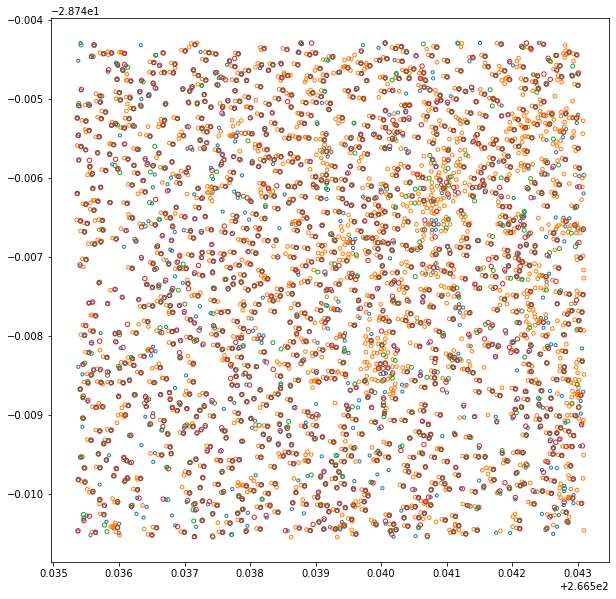

In [15]:
pl.figure(figsize=(10,10))
ax = pl.gca()
for ii, (ww, tbl) in enumerate(zip(wcses, tbls)):
    crds = tbl['skycoords']
    crds = crds[reg.contains(crds, ww)]
    markers = ax.scatter(crds.ra, crds.dec, s=10+3*ii)
    markers.set_edgecolors(markers.get_facecolors())
    markers.set_facecolors('none')
ax.axis()

In [16]:
tbls[0].meta['filter'], len(tbls[0])

('f410m', 73274)

In [17]:
basetable = tbls[0].copy()
basecrds = basetable['skycoords']
for colname in basetable.colnames:
    basetable.rename_column(colname, colname+"_"+basetable.meta['filter'])
#basetable = basetable[[cn for cn in basetable.colnames if not any(x in cn for x in ignored_columns)]]

for tbl in tbls[1:]:
    wl = tbl.meta['filter']
    print(wl)
    #tbl = tbl[[cn for cn in tbl.colnames if not any(x in cn for x in ignored_columns)]]
    crds = tbl['skycoords']
    matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
    basetable.add_column(name=f"sep_{wl}", col=sep)
    basetable.add_column(name=f"id_{wl}", col=matches)
    matchtb = tbl[matches]
    for cn in matchtb.colnames:
        #matchtb[cn][sep > 0.1*u.arcsec].mask = True
        matchtb.rename_column(cn, f"{cn}_{wl}")
    basetable = table.hstack([basetable, matchtb], join_type='exact')
    basetable.meta[f'{wl}_pixelscale'] = tbl.meta['pixelscale']
    #if 'sky_centroid_f444w' in basetable.colnames:
    #    basetable.rename_column('sky_centroid_f444w', 'sky_centroid')
    #basetable = table.join(basetable, tbl,
    #                      table_names=['', wl],
    #                      join_type='outer',
    #                      join_funcs={'sky_centroid': table.join_skycoord(0.1*u.arcsec)})
    #if 'sky_centroid_' in basetable.colnames:
    #    basetable.rename_column('sky_centroid_', 'sky_centroid_f444w')
    basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.ecsv", overwrite=True)
    basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.fits", overwrite=True)

f212n


f466n


f405n


f187n


f182m


In [18]:
len(basetable)

73274

In [19]:
basetable[reg.contains(basetable['skycoords_f405n'],ww)][:5]

<Table length=5>
     x_f410m           y_f410m       flux_f410m passno_f410m   dx_f410m     dy_f410m   dflux_f410m ... fluxiso_f182m      xiso_f182m         yiso_f182m     sky_f182m             skycoords_f182m            flux_jy_f182m mag_ab_f182m
                                                                                                   ...                                                                                deg,deg                      Jy        mag(AB)   
     float64           float64        float32     float64      float32      float32      float32   ...    float32          float64            float64        float32                  SkyCoord                  float32      float32   
----------------- ------------------ ---------- ------------ ------------ ------------ ----------- ... ------------- ------------------- ------------------ ---------- ------------------------------------- ------------- ------------
687.0818916258428 1120.2233365960574  1895.8807          0.0 0.0016421885 0.0015205553   1.8027263 ...    59368740.0 -0.4826532616323001 1.2150103236147507 -5.1998196 266.5353029874153,-28.743830730483275    -12.930278          nan
985.5153025613168  1119.610893653205  121.45756          0.0  0.009877447  0.009507876  0.67471033 ...    59368740.0 -0.4826532616323001 1.2150103236147507 -5.1998196 266.5353029874153,-28.743830730483275    -12.930278          nan
724.2859189410157 1121.1013841115384  319.90762          0.0   0.00576148   0.00557189   1.1203445 ...    59368740.0 -0.4826532616323001 1.2150103236147507 -5.1998196 266.5353029874153,-28.743830730483275    -12.930278          nan
793.3177299337443 1120.3400918086745  19.241325          0.0   0.06447453  0.063141935  0.69773394 ...    59368740.0 -0.4826532616323001 1.2150103236147507 -5.1998196 266.5353029874153,-28.743830730483275    -12.930278          nan
806.5116369363893  1122.552840625075  32.907574          0.0  0.037378598   0.03874215   0.6698803 ...    59368740.0 -0.4826532616323001 1.2150103236147507 -5.1998196 266.5353029874153,-28.743830730483275    -12.930278          nan

In [20]:
basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m', 'skycoords_f410m', 'x_f410m', 'y_f410m']

<Table length=5>
flux_f410m            skycoords_f410m                  x_f410m           y_f410m      
                          deg,deg                                                     
 float32                  SkyCoord                     float64           float64      
---------- -------------------------------------- ----------------- ------------------
 1895.8807  266.5353719101744,-28.750479006192098 687.0818916258428 1120.2233365960574
 319.90762  266.53537713199114,-28.74982873622569 724.2859189410157 1121.1013841115384
 32.907574 266.53537892503925,-28.748391696889005 806.5116369363893  1122.552840625075
 3.9234338 266.53541126595456,-28.749541900595755 740.6702636106979  1123.085521372023
  88.21324  266.5354088708761,-28.748677238556915 790.1481043738926 1123.7845951621384

In [21]:
#(500*u.Jy).to(u.ABmag)
(basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m'] * u.Jy).to(u.ABmag)

<Magnitude [0.70547247, 2.6374385 , 5.10676   , 7.415834  , 4.036165  ] mag(AB)>

In [22]:
tbls[5][20:30]

<Table length=10>
        x                  y                 flux        passno       dx            dy          dflux     ...  fluxiso           xiso                  yiso            sky                   skycoords                   flux_jy        mag_ab  
                                                                                                          ...                                                                                 deg,deg                       Jy         mag(AB)  
     float64            float64            float32      float64    float32       float32       float32    ...  float32         float64               float64         float32                  SkyCoord                   float32       float32  
------------------ ------------------ ----------------- ------- ------------- ------------- ------------- ... ---------- -------------------- --------------------- ---------- -------------------------------------- -------------- -----------
 1930.356159644282  5.268115050982947        -4173.4233     0.0 0.00072913495  0.0007884737      2.534319 ...   518.7026 -0.22738014158626843 -0.057524194488789274  -5.317006 266.53387363432716,-28.727264950641374  -0.0007644332         nan
 2365.405321275693  4.959547121039538        -1283.2921     0.0  0.0021468867  0.0020678078     1.5407072 ...  239.13368  0.35234290877314217   0.03002204906691067  -4.970781 266.53381139621257,-28.723529276272377 -0.00023440468         nan
 2529.909709444335  4.333611399350384         -710.3747     0.0  0.0036527857   0.003440202     1.4906305 ... -58.421608   2.9899118987201594    3.1643715775918233 -5.7137876 266.53378287692226,-28.722116772959865 -0.00012976899         nan
 27.66298633813858  6.515789806842804 255205460000000.0     0.0         1e+20         1e+20 10000000000.0 ...        0.0                  0.0                   0.0 -5.1018014 266.53414488831817,-28.743602982600034     46818852.0 -10.2760515
1243.6374587841015 6.6087616155721705        -763.04584     0.0  0.0040122257  0.0042248107     2.2997231 ...  282.56934   0.2697955942782296   0.06973849856013976  -6.097042 266.53398024411445,-28.733161555716197 -0.00013999043         nan
1771.6592319443607  7.521162204966377        -2486.1106     0.0  0.0010464343 0.00093611877      1.406978 ...  214.59683  0.03183513404752536  -0.43980990794960517  -5.688507 266.53391729877245,-28.728627391804178 -0.00045618758         nan
1848.1073345782568  6.433355089676691          4142.258     0.0 0.00052009727 0.00054016564     1.3158594 ...  21.672544  -0.1614613838051054    -29.47258506044582 -5.4296913  266.5338962403303,-28.727971071631696   0.0007577277   16.701218
1851.8245788885392 6.1681004748210775         4625.3613     0.0 0.00048391856     0.0005197     1.5212811 ... -213.81569 -0.48560801420147903    -2.897332940830144  -5.416069 266.53389313691105,-28.727939183795723  0.00084342464   16.584885
2064.0028575367696  6.097093963883473        -2187.9724     0.0  0.0010756502  0.0010251864     1.5302812 ...  359.54333   0.4052057052759594     0.274969027755002 -4.9315286  266.5338635599259,-28.726117244684385 -0.00039790446         nan
 2103.090500801362  6.239848996865073        -1400.5992     0.0  0.0013630628  0.0013430484     1.0970362 ...  220.37083  0.10045428948161235     0.114530671628599  -4.652316 266.53385963728414,-28.725781587079013 -0.00025537648         nan

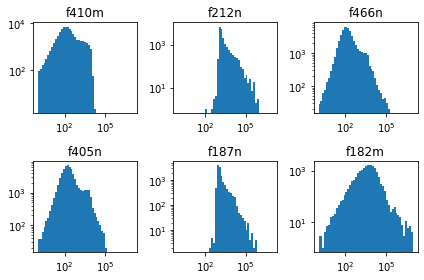

In [23]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux'], bins=np.logspace(0,7), log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

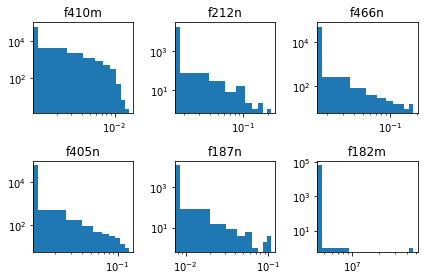

In [24]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux_jy'], log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

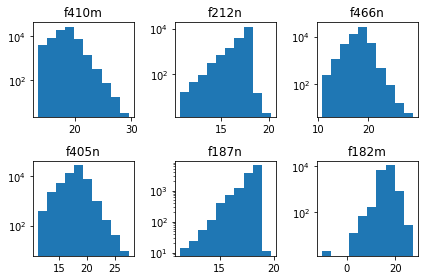

In [25]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['mag_ab'], log=True)
    ax.set_title(tbl.meta['filter'])
    #ax.loglog()
pl.tight_layout()

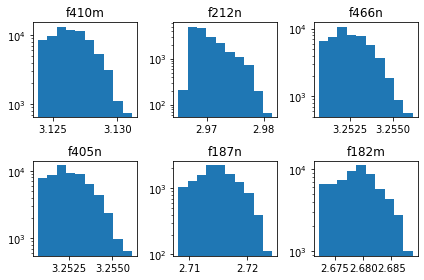

In [26]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['fwhm'], log=True)
    ax.set_title(tbl.meta['filter'])
pl.tight_layout()

# XMatch Check

In [27]:
len(tbls[0]), tbls[0].meta['filter']

(73274, 'f410m')

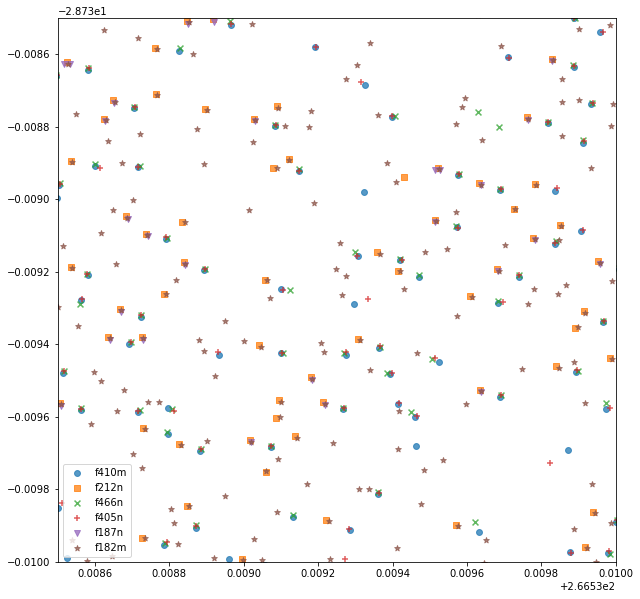

In [28]:
pl.figure(figsize=(10,10))
for tbl,marker in zip(tbls, 'osx+v*'):
    crds = tbl['skycoords']
    pl.scatter(crds.ra, crds.dec, alpha=0.75, s=35,
               marker=marker, label=tbl.meta['filter'])
pl.axis((266.5385, 266.54, -28.740, -28.7385))
pl.legend(loc='best')

# Color-magnitude and color-color diagrams

(25.0, 13.0)

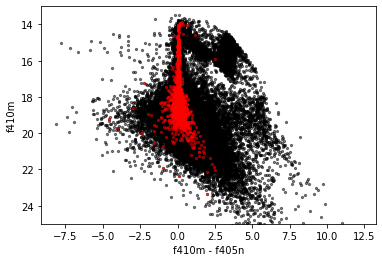

In [29]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

(25.0, 14.0)

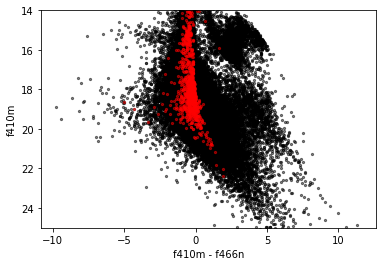

In [30]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m")
pl.ylim(25,14)

(-5.0, 10.0, -5.0, 10.0)

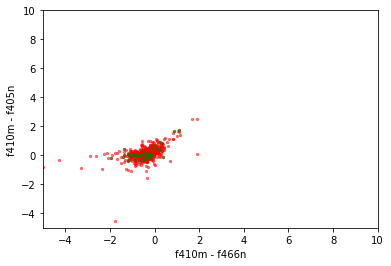

In [31]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
#pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

(25.0, 14.0)

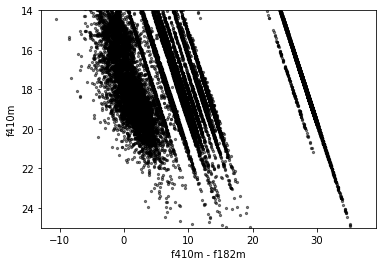

In [32]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f182m'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.xlabel("f410m - f182m")
pl.ylabel("f410m")
pl.ylim(25,14)

(25.0, 14.0)

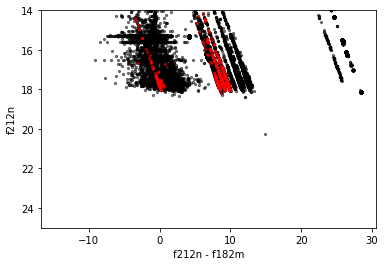

In [33]:
sel = reg.contains(basetable['skycoords_f212n'], ww)
pl.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'], basetable['mag_ab_f212n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f212n'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f212n - f182m")
pl.ylabel("f212n")
pl.ylim(25,14)

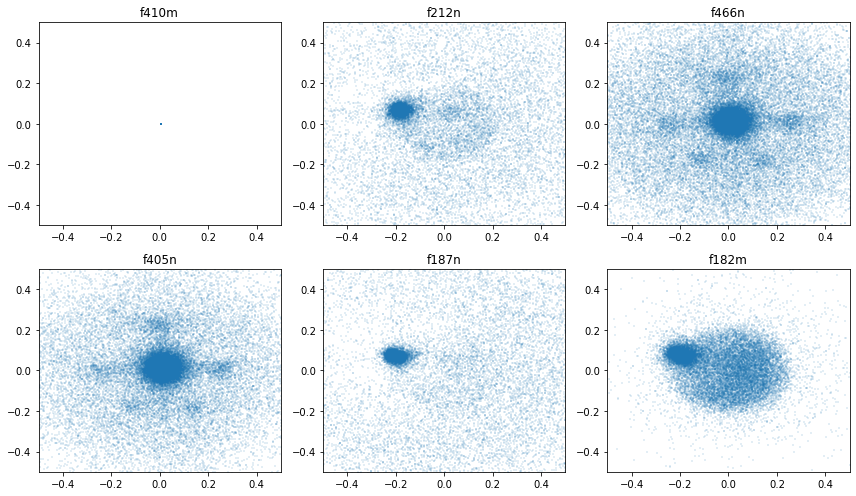

In [34]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    ax.scatter((crds.ra-basecrds.ra).to(u.arcsec), (crds.dec-basecrds.dec).to(u.arcsec), marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [35]:
import PIL
import pyavm

In [36]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png'))
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [37]:
wwi

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.5356389808593  -28.712998625026  
CRPIX : 2829.531214097682  1167.45507920672  
PC1_1 PC1_2  : -0.01526213458185807  0.9998835268410042  
PC2_1 PC2_2  : 0.9998835268410042  0.01526213458185807  
CDELT : 1.74999921246059e-05  1.74999921246059e-05  
NAXIS : 5683  2329

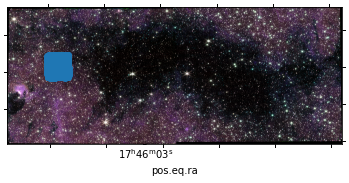

In [38]:
ax = pl.subplot(projection=wwi)
ax.imshow(img)
crds = basetable['skycoords_f410m']
ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('fk5'))

In [40]:
fh = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
ww410 = wcs.WCS(fh[1].header)

Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.654832 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526328725.126 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


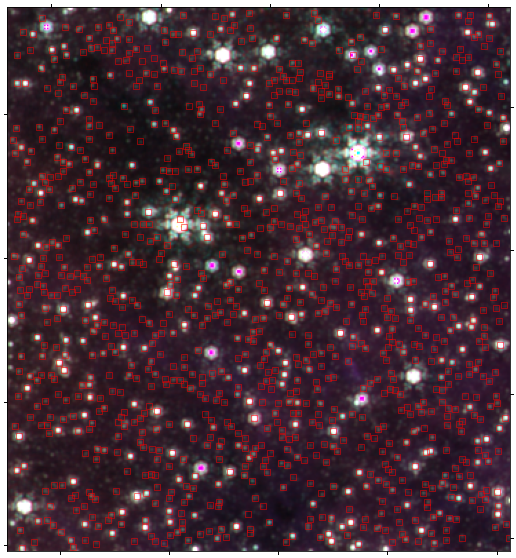

In [41]:
mask = reg.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(10,10))
ax = pl.subplot(projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby > 2)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  edgecolor='r', facecolor='none', marker='s',
                  alpha=0.5)#r'$\rightarrow$')
                  #c=colorby[sel],
                  #norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

<SkyCoord (ICRS): (ra, dec) in deg
    (266.54178784, -28.74908469)>

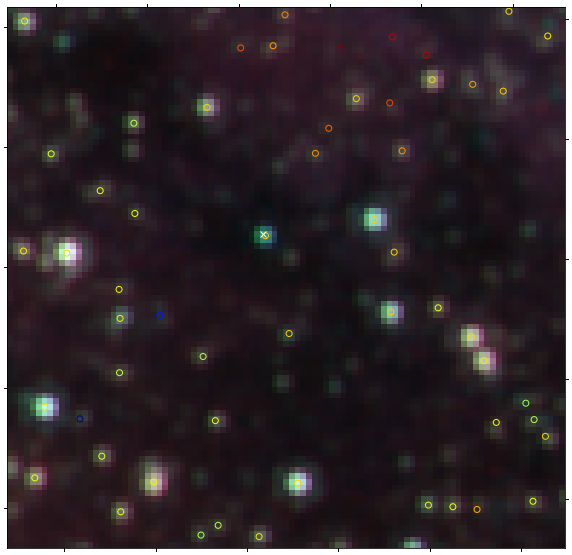

In [42]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(10,10))
ax = pl.subplot(projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

In [43]:
import warnings

In [44]:
def starzoom(coords):
    reg = regions.RectangleSkyRegion(center=coords, width=1*u.arcsec, height=1*u.arcsec)
    ii = 0
    pl.figure(figsize=(12,4))
    filters_plotted = []
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for fn in sorted(glob.glob(f'{basepath}/F*/pipeline/*nircam*nrc*_i2d.fits')):
            filtername = fits.getheader(fn)['PUPIL']+fits.getheader(fn)['FILTER']
            if filtername in filters_plotted:
                continue
            ww = wcs.WCS(fits.getheader(fn, ext=('SCI',1)))
            if ww.footprint_contains(coords):
                print(fn)
                data = fits.getdata(fn, ext=('SCI',1))
                mask = reg.to_pixel(ww).to_mask()
                slcs,_ = mask.get_overlap_slices(data.shape)
                ax = pl.subplot(1,6,ii+1)
                ax.imshow(data[slcs], norm=simple_norm(data[slcs], stretch='asinh'),
                          origin='lower', cmap='gray')
                xx, yy = ww[slcs].world_to_pixel(coords)
                ax.plot(xx, yy, 'rx')
                ax.set_title(filtername)
                filters_plotted.append(filtername)
                ii += 1

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


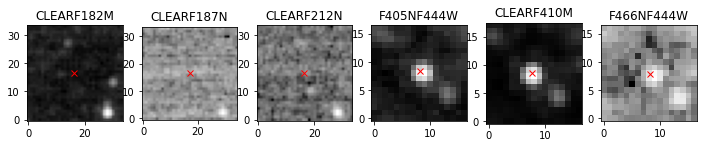

In [45]:
starzoom(coordinates.SkyCoord(266.54177, -28.74910, unit=(u.deg, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


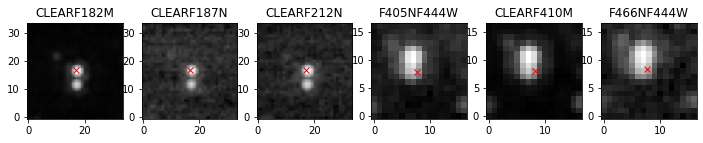

In [46]:
starzoom(coordinates.SkyCoord("17:46:10.006 -28:44:21.00", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


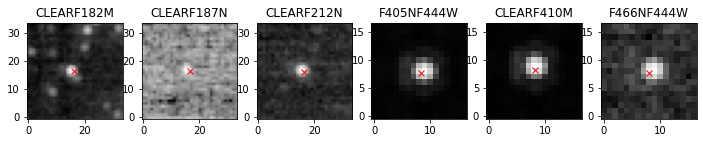

In [47]:
starzoom(coordinates.SkyCoord("17:46:10.682 -28:42:23.87", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


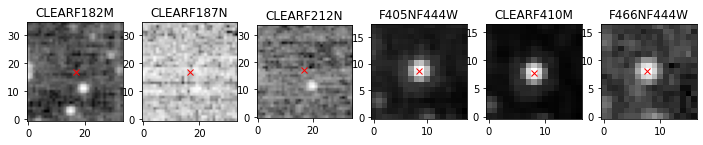

In [48]:
starzoom(coordinates.SkyCoord("17:46:09.310 -28:44:08.95", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


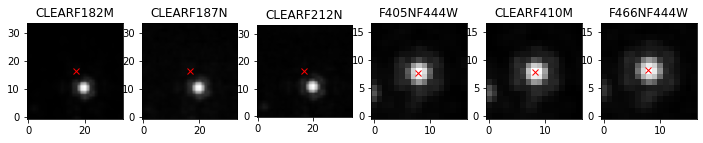

In [49]:
starzoom(coordinates.SkyCoord("17:46:09.256 -28:44:11.15", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


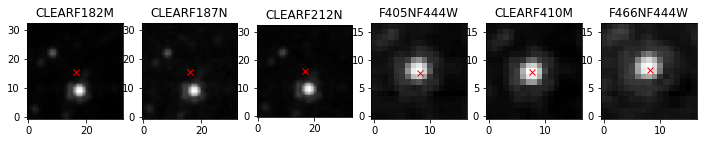

In [50]:
starzoom(coordinates.SkyCoord("17:46:03.833 -28:42:59.76", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca1_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca1_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca1_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


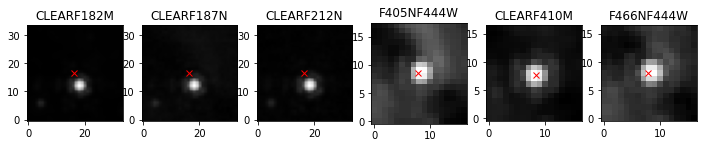

In [51]:
starzoom(coordinates.SkyCoord("17:46:07.378 -28:45:29.38", unit=(u.hour, u.deg), frame='icrs'))

In [52]:
ww410

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.535615939416  -28.737346514815  
CRPIX : 1439.318615916805  1145.909016366914  
PC1_1 PC1_2  : -0.01655757177857967  0.9998629140121146  
PC2_1 PC2_2  : 0.9998629140121146  0.01655757177857967  
CDELT : 1.74740513809727e-05  1.74740513809727e-05  
NAXIS : 2901  2297

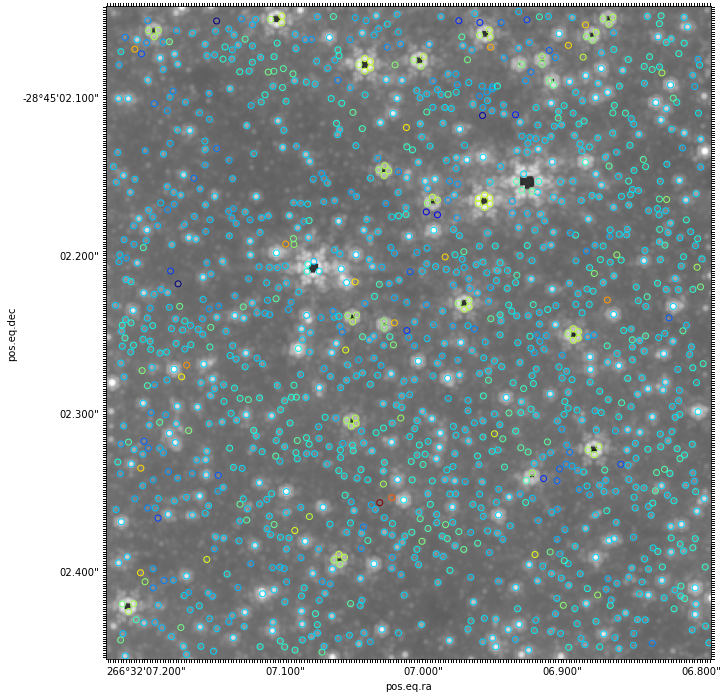

In [53]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410[slcs])
co = mask.cutout(fh['SCI'].data)
co = fh['SCI'].data[slcs]
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=0.1 * u.arcsec)
lat.set_ticks(spacing=0.1 * u.arcsec)

In [54]:
tbls[0].meta

OrderedDict([('filename',
              '/orange/adamginsburg/jwst/brick/F410M/f410m_nrca_crowdsource.fits'),
             ('filter', 'f410m'),
             ('pixelscale', <Quantity 3.05342472e-10 deg2>)])

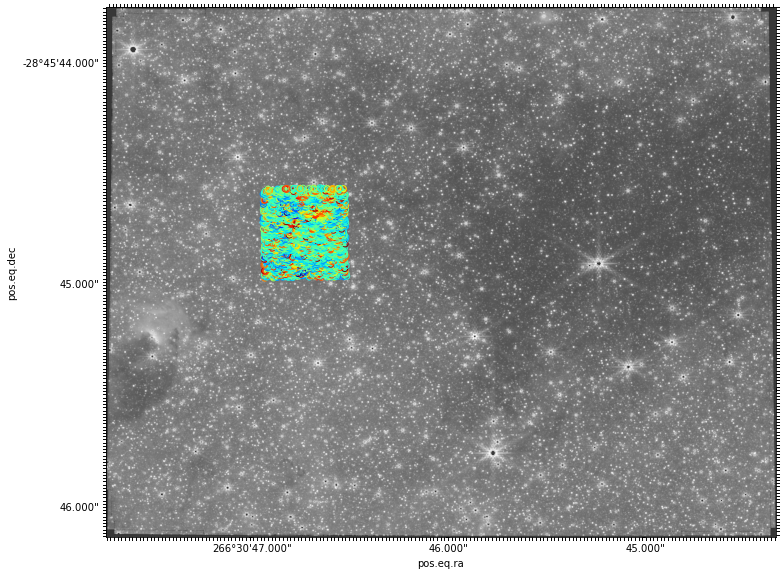

In [55]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

(676.0, 1043.0, 1119.0, 1515.0)

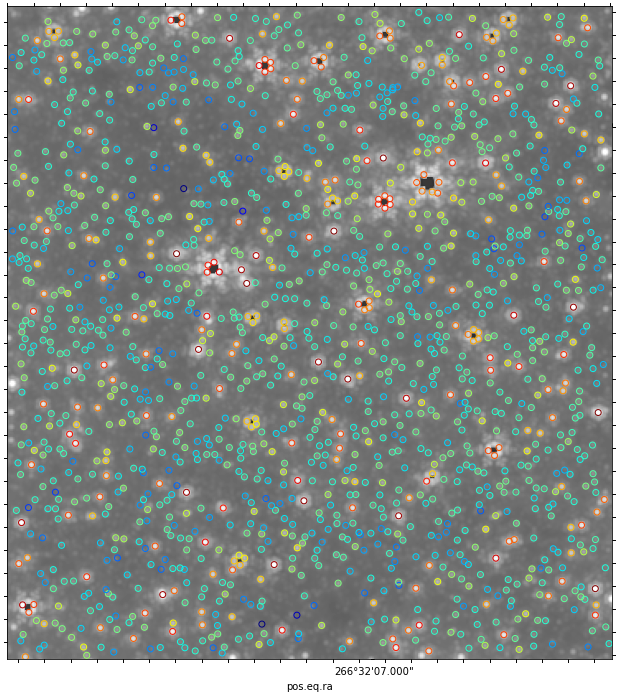

In [56]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)
ax.axis((676,1043,1119,1515))